In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [15]:
# Find PR

df_pr_control = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'piControl' & member_id=='r1i1p1f1'")
#df_sst_control = df_sst_control.drop_duplicates('source_id').head(44)
df_pr_control = df_pr_control.drop_duplicates('source_id')
df_pr_control = df_pr_control[~df_pr_control['source_id'].isin(['MCM-UA-1-0','GISS-E2-1-G-CC','NorESM1-F','IITM-ESM',
                                                                  'GISS-E2-2-G','AWI-ESM-1-1-LR','EC-Earth3-LR',
                                                                  'E3SM-1-1-ECA','MIROC-ES2H','ICON-ESM-LR',
                                                                  'KIOST-ESM','NESM3','KACE-1-0-G','GISS-E2-1-H','MPI-ESM-1-2-HAM',
                                                                  'HadGEM3-GC31-LL','EC-Earth3-Veg','CAS-ESM2-0','FIO-ESM-2-0','CIESM'])]
print(len(df_pr_control))
df_pr_control

38


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9402,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
18373,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
32289,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40393,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181016
44322,CMIP,MIROC,MIROC6,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/piControl/r...,NaN,20181212
44813,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181214
55606,CMIP,MRI,MRI-ESM2-0,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/piControl...,NaN,20190222
67574,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
67696,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320
89838,CMIP,CCCma,CanESM5,piControl,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/piControl/...,NaN,20190429


In [16]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=3000) #250 years
new_time_index
    
dset_list_pr = []
for zstore in df_pr_control.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
    name_list = name.split('.')
    name = name_list[1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    print(ds.time)
    ds_sel = ds.isel(time=slice(len(ds.time)-3000,len(ds.time)))
    print(ds_sel.time.head(1).values)
    print(ds_sel.time.tail(1).values)
    ds_pr_interp = ds_sel.assign(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_pr = ds_pr_interp.pr
    ds_pr['name'] = name # Creating a new dimension for each ensemble member
    dset_list_pr.append(ds_pr)

GFDL-CM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(151, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 3, 16, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(650, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  noleap
    description:    for time-mean fields
    long_name:      time
    standard_name:  time
[cftime.DatetimeNoLeap(401, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeNoLeap(650, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
GFDL-ESM4
<xarray.DataArray 'time' (time: 6000)>
array([cftime.Datetim

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 9600)>
array([cftime.DatetimeGregorian(3200, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 2, 15, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3200, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3999, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 3200-01-16 12:00:00 ... 3999-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeGregorian(3750, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3999, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
BCC-ESM1
<xarray.DataArray 'time' (time: 5412)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0,

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 12000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2849, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2849-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2600, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2849, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
MPI-ESM1-2-HR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2349, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2100, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
E3SM-1-0
<xarray.DataArray 'time' (t

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(2401, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2401, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2900, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2401-01-16 12:00:00 ... 2900-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2651, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2900, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
FGOALS-f3-L
<xarray.DataArray 'time'

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeProlepticGregorian(950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1449, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(1200, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(1449, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
CESM2-WACCM-FV2
<xarray.DataArray 'time

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2300, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2300, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2800, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2300-01-16 12:00:00 ... 2800-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2551, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2800, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
EC-Earth3


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

<xarray.DataArray 'time' (time: 6012)>
array([cftime.DatetimeProlepticGregorian(2259, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2259, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(2759, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2259-01-16 12:00:00 ... 2759-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(2510, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(2759, 12, 16, 12, 0, 0, 0, has_year_zero=True)]
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'time' (time: 14400)>
array([cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1850, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(3049, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 3049-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bounds
    long_name:      Time axis
    standard_name:  time
[cftime.DatetimeGregorian(2800, 1, 16, 12, 0, 0, 0, has_year_zero=False)]
[cftime.DatetimeGregorian(3049, 12, 16, 12, 0, 0, 0, has_year_zero=False)]
CMCC-CM2-SR5
<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1850, 1, 16

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


<xarray.DataArray 'time' (time: 12000)>
array([cftime.DatetimeProlepticGregorian(101, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(101, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeProlepticGregorian(1100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0101-01-16 12:00:00 ... 1100-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time
[cftime.DatetimeProlepticGregorian(851, 1, 16, 12, 0, 0, 0, has_year_zero=True)]
[cftime.DatetimeProlepticGregorian(1100, 12, 16, 12, 0, 0, 0, has_year_zero=True)]


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [17]:
pr_control = xr.concat(dset_list_pr, dim='name', coords='minimal', compat='override')
pr_control.load()

<xarray.DataArray 'pr' (name: 38, time: 3000, lat: 88, lon: 179)>
array([[[[6.45036044e-07, 6.44398685e-07, 6.44119922e-07, ...,
          6.47560492e-07, 6.46933103e-07, 6.46303332e-07],
         [9.54248733e-07, 8.94603008e-07, 8.74220277e-07, ...,
          1.03786963e-06, 1.03249667e-06, 1.02710521e-06],
         [1.45775758e-06, 1.43955670e-06, 1.40082645e-06, ...,
          1.74009554e-06, 1.73536196e-06, 1.72500858e-06],
         ...,
         [4.97795163e-06, 4.95414986e-06, 4.96712619e-06, ...,
          4.10119128e-06, 4.09697259e-06, 4.12867273e-06],
         [3.63146652e-06, 3.75177693e-06, 3.73603638e-06, ...,
          3.46867499e-06, 3.46541697e-06, 3.46214723e-06],
         [3.06046203e-06, 3.05509475e-06, 3.04528811e-06, ...,
          3.08154051e-06, 3.07632911e-06, 3.07108072e-06]],

        [[8.29801274e-07, 8.26976597e-07, 8.26465993e-07, ...,
          8.40906230e-07, 8.38158911e-07, 8.35393206e-07],
         [1.13087917e-06, 1.09154295e-06, 1.07686762e-06, ...,
          1.15389214e-06, 1.15190804e-06, 1.14991601e-06],
         [1.21883011e-06, 1.21180434e-06, 1.17775406e-06, ...,
          1.61709556e-06, 1.61249082e-06, 1.59589078e-06],
...
         [1.80909132e-05, 1.78269473e-05, 1.79333942e-05, ...,
          2.30710340e-05, 2.15682761e-05, 1.97969293e-05],
         [1.72424872e-05, 1.74124936e-05, 1.77672324e-05, ...,
          1.68733446e-05, 1.68177715e-05, 1.69241790e-05],
         [1.20094969e-05, 1.21102975e-05, 1.21516526e-05, ...,
          1.16440492e-05, 1.17581195e-05, 1.18334682e-05]],

        [[5.25826852e-07, 4.99702455e-07, 4.72508706e-07, ...,
          5.94300547e-07, 5.85683866e-07, 5.69437555e-07],
         [3.72018373e-07, 3.64367963e-07, 3.52678986e-07, ...,
          3.89379884e-07, 3.88908669e-07, 3.89438048e-07],
         [3.22398413e-07, 2.91922024e-07, 2.67438268e-07, ...,
          3.73993733e-07, 3.75766488e-07, 3.69912976e-07],
         ...,
         [1.56431415e-05, 1.58415952e-05, 1.62699689e-05, ...,
          1.49853424e-05, 1.51343129e-05, 1.53127652e-05],
         [1.39155483e-05, 1.41166234e-05, 1.42923891e-05, ...,
          1.34679379e-05, 1.35076234e-05, 1.36536333e-05],
         [7.24523503e-06, 7.28107922e-06, 7.32413006e-06, ...,
          7.26651836e-06, 7.24431754e-06, 7.23910214e-06]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U17 'GFDL-CM4' 'GFDL-ESM4' ... 'CMCC-ESM2' 'ACCESS-ESM1-5'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

In [18]:
pr_control.to_netcdf('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_pr_39model_piControl_2x2_last250.nc')

Text(0.5, 0.99, 'Mean PR')

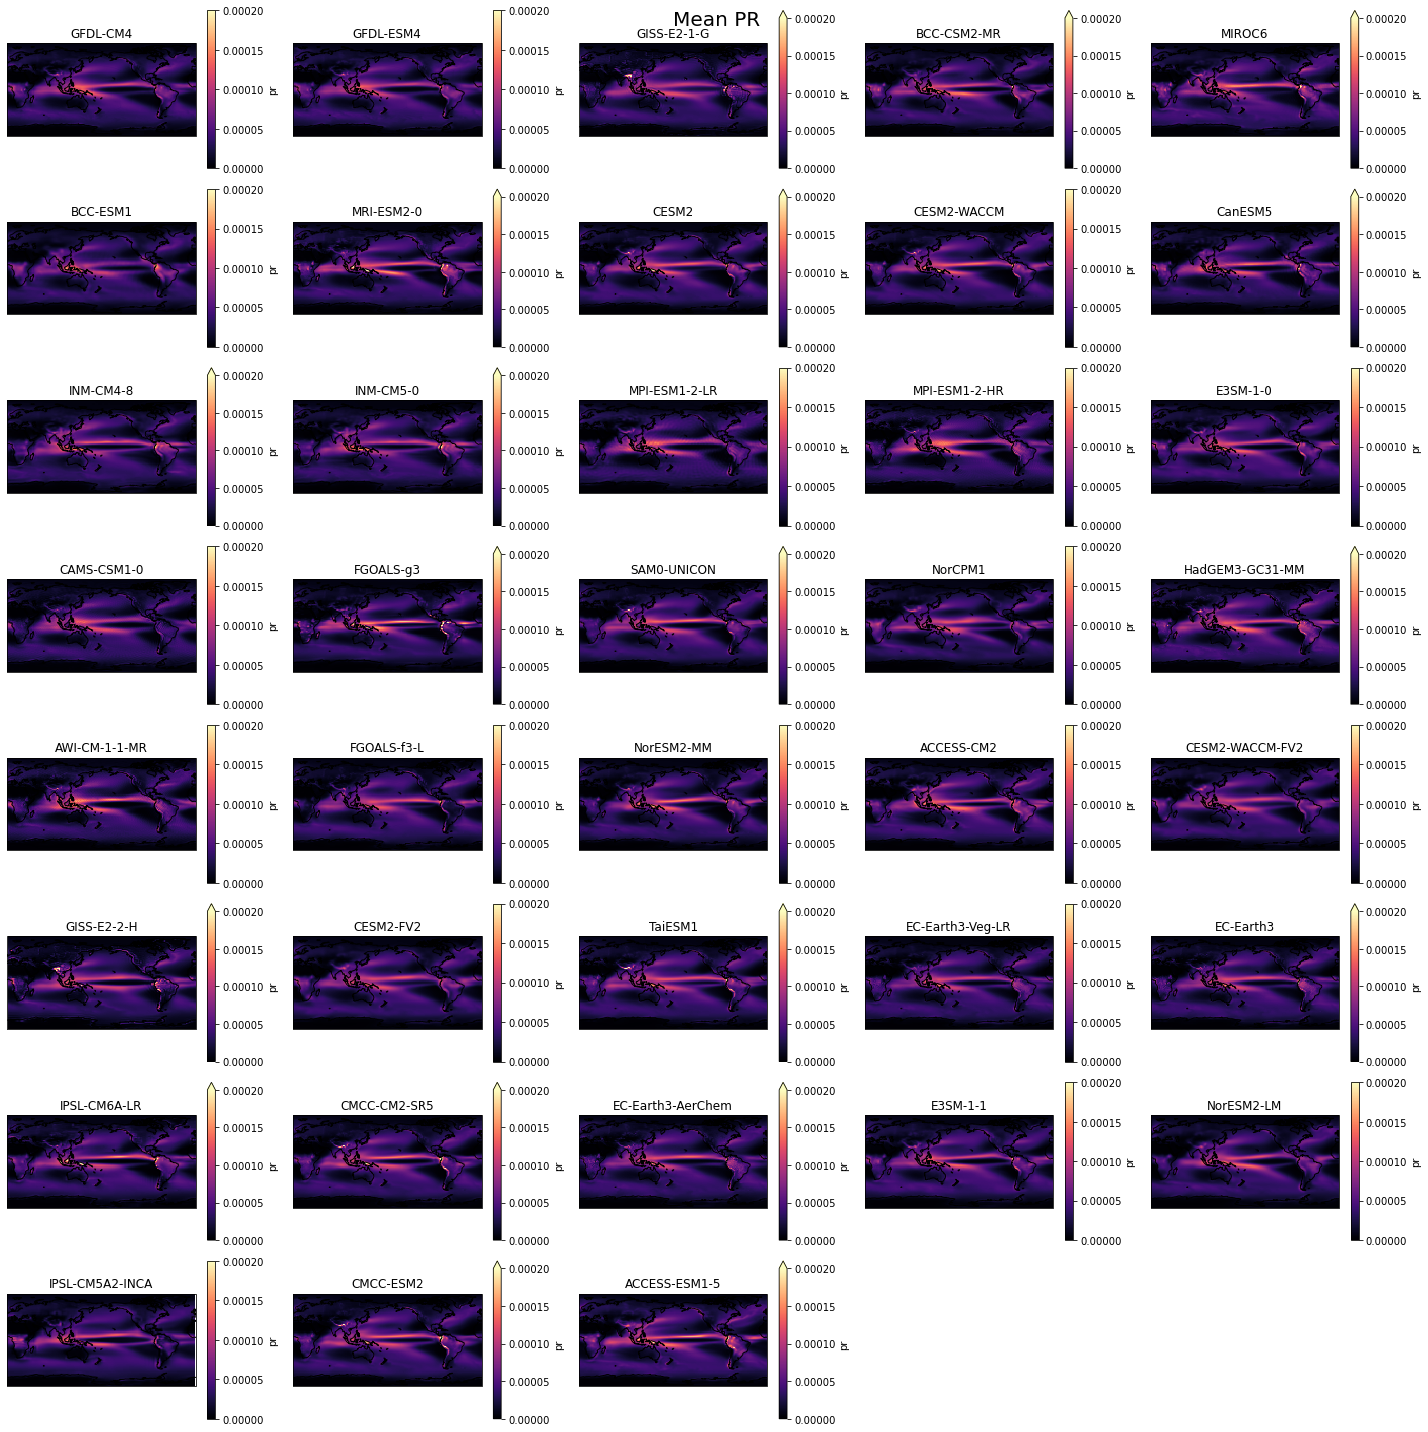

In [21]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

i = 1

for model in pr_control['name'].values:
    ax = fig.add_subplot(8,5,i, projection=ccrs.PlateCarree(central_longitude=180))
    pr_control.sel(name=model).mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=0.0002, cmap='magma')
    ax.coastlines(color='black', linewidth=1)
    plt.title(model)
    i += 1
plt.tight_layout()
plt.suptitle('Mean PR', fontsize=20, y=0.99)